In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import plotly

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("../data/raw/dump_ml_data_vacancies.csv")

/var/folders/6h/gp_g8g892lx9ry58s6xzbnx80000gn/T/ipykernel_5085/753128051.py:1: DtypeWarning: Columns (32,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/dump_ml_data_vacancies.csv")


### Посмотрим на информацию по всем признакам

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102196 entries, 0 to 102195
Data columns (total 72 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   _id                           102196 non-null  object 
 1   accept_handicapped            102196 non-null  bool   
 2   accept_incomplete_resumes     102196 non-null  bool   
 3   accept_kids                   102196 non-null  bool   
 4   accept_temporary              102196 non-null  bool   
 5   address.building              49308 non-null   object 
 6   address.city                  54946 non-null   object 
 7   address.description           0 non-null       float64
 8   address.lat                   55146 non-null   float64
 9   address.lng                   55146 non-null   float64
 10  address.metro                 0 non-null       float64
 11  address.metro_stations        4351 non-null    object 
 12  address.raw                   56086 non-null

Сразу уберем все признаки с постфиксом id так как они будут идентификаторами признаков с постфиксом name

In [4]:
df = df.drop(columns=[x for x in df.columns.to_list() if '.id' in x])

In [5]:
all_cols = df.columns.to_list()

In [6]:
df = df.rename(columns={i:i.replace(".", "_") for i in all_cols})

__________________

In [7]:
df["salary_mean"] = df[['salary_from', 'salary_to']].mean(axis=1)
df["salary_mean"] = df.apply(lambda x: x["salary_mean"] if x["salary_gross"]==False else x["salary_mean"]*0.87, axis=1)

In [8]:
df[['salary_gross','salary_from', 'salary_to','salary_mean']].head(3)

salary_gross  salary_from  salary_to  salary_mean
0        False      60000.0   150000.0     105000.0
1        False      50000.0    60000.0      55000.0
2        False     200000.0        NaN     200000.0

### удаление строк с валютной зарплатой

In [9]:
df["salary_currency"].value_counts()

RUR    86755
USD       64
EUR       27
BYR        4
KZT        3
Name: salary_currency, dtype: int64

In [10]:
df = df.drop(df[df["salary_currency"].isin(["USD", "EUR", "BYR", "KZT"])].index)

### удаление колонки валюты и признаки зарплаты (кроме salary.mean и salary.gross)

In [11]:
df = df.drop(columns=['salary_currency', 'salary_from', 'salary_to'])

### описать address.lat, address.lng,	сделать преобразования

In [12]:
# df.loc[df[df["address.lat"]==0].index.to_list(), "address.lat"] = np.nan
# df.loc[df[df["address.lng"]==0].index.to_list(), "address.lat"] = np.nan

In [13]:
df[["address_lat"]].isna().sum()

address_lat    46982
dtype: int64

In [14]:
df[["address_lng"]].isna().sum()

address_lng    46982
dtype: int64

### Будем рассматривать каждую признак по отдельности

### id (идентификатор вакансии на сайте HH.ru)

In [15]:
df.id.sample(2)

62425    68856670
49595    70988081
Name: id, dtype: int64

In [16]:
# Посмотрим количество уникальных значений id
df.id.nunique()

102098

In [17]:
# Число уникальных = мощности датасета, для удобства поставим id в качестве индекса
df = df.set_index('id')

In [18]:
df = df.drop(columns=['_id'])

__________________

### description (текстовое описание вакансии)

In [19]:
df[["description"]].head(3)

description
id                                                         
69761814  <p><strong>Приветствуем вас!</strong></p> <p>М...
69683316  <p><strong>Обязанности:</strong></p> <p> </p> ...
70089465  <p>Компания &quot;Обаяние продаж&quot; более 1...

In [20]:
df["description"] = df["description"].str.replace("<[^>]*>", "")
df["description"] = df["description"].str.lower()

/var/folders/6h/gp_g8g892lx9ry58s6xzbnx80000gn/T/ipykernel_5085/83928959.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["description"] = df["description"].str.replace("<[^>]*>", "")


In [21]:
df[["description"]].head(3)

description
id                                                         
69761814  приветствуем вас! мы рады, что вы проявили инт...
69683316  обязанности:   -ведение деловой переписки; -ве...
70089465  компания &quot;обаяние продаж&quot; более 10 л...

Оставим description без изменений. Для первой итерации модели не будем использовать.

In [24]:
tfidf_cols = ["description"]

__________________

### key_skills (список ключевых навыков)

In [25]:
df[['key_skills']].sample(3)

key_skills
id                                                         
70744956  [{"name":"Пользователь ПК"},{"name":"Деловое о...
69850894  [{"name":"Грамотная речь"},{"name":"Пользовате...
70407822  [{"name":"Пользователь ПК"},{"name":"Работа в ...

В признаке вложенный JSON, можно его раскрыть

In [26]:
df['key_skills'] = df.apply(lambda x: eval(x['key_skills']) if isinstance(x['key_skills'], str) else x['key_skills'], axis=1)
df['key_skills'] = df.apply(lambda x: [i['name'] for i in x['key_skills']] if isinstance(x['key_skills'], list) else x['key_skills'], axis=1)
df['key_skills'] = df.apply(lambda x: ", ".join(set(x['key_skills'])).lower() if isinstance(x['key_skills'], list) else x['key_skills'], axis=1)

In [27]:
df[['key_skills']].sample(3)

key_skills
id                                                         
70876523  ms dos, капитальный ремонт, реконструкция, пол...
71239597  деловое общение, пользователь пк, навыки межли...
68398050  1с: документооборот, движение денежных средств...

In [28]:
df['key_skills'].nunique()

53898

In [29]:
df[['key_skills']].head(3)

key_skills
id                                                         
69761814  активные продажи, грамотная речь, проведение п...
69683316  протоколирование, делопроизводство, грамотная ...
70089465  поиск и привлечение клиентов, активные продажи...

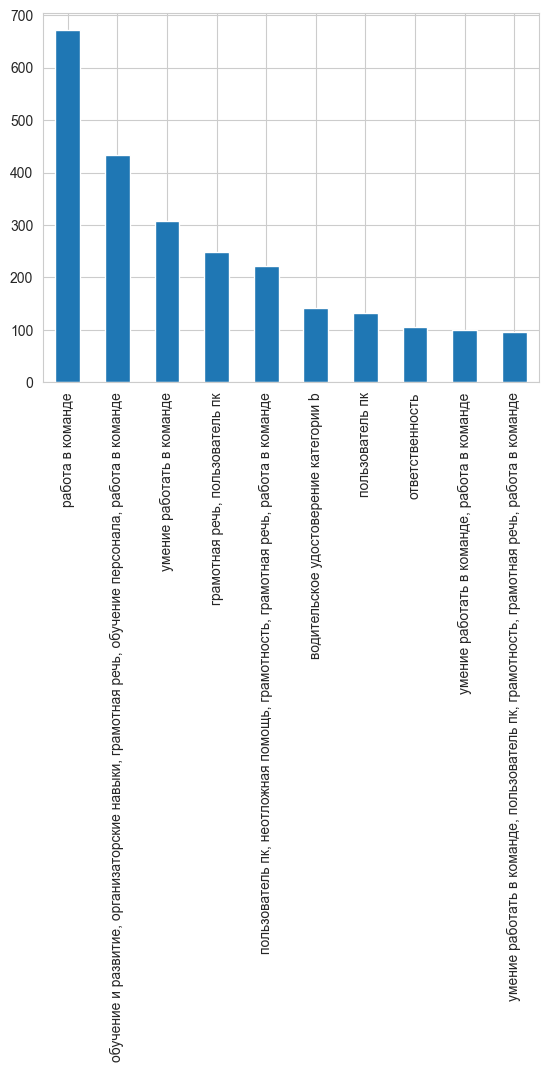

In [30]:
# топ 10 key skills по частоте упоминания в вакансиях
df[['key_skills']].explode(column='key_skills')['key_skills'].value_counts()[:10].plot(kind='bar');

In [31]:
tfidf_cols.append("key_skills")

Из признака можно будет сделать векторное представление через tfidf и попробовать использовать его в модели.

__________________

### schedule.name (тип занятости)

In [32]:
df[["schedule_name"]].sample(3)

schedule_name
id                      
71088655     Полный день
70094789  Сменный график
70807908  Вахтовый метод

In [33]:
df[["schedule_name"]].value_counts()

schedule_name   
Полный день         71448
Сменный график      12762
Вахтовый метод       8068
Удаленная работа     6325
Гибкий график        3495
dtype: int64

5 уникальных значений, признак можно закодировать через OHE

__________________

### accept_handicapped (указание, что вакансия доступна для соискателей с инвалидностью)

In [34]:
df[['accept_handicapped']].sample(3)

accept_handicapped
id                          
71032152               False
70332893               False
69261399               False

In [35]:
df[['accept_handicapped']].value_counts()

accept_handicapped
False                 97568
True                   4530
dtype: int64

In [36]:
df.groupby('accept_handicapped')['salary_mean'].describe()

count          mean           std    min      25%  \
accept_handicapped                                                        
False               82546.0  54024.076701  37442.208110   0.87  30015.0   
True                 4209.0  39681.113497  26421.186944  30.00  22620.0   

                        50%      75%       max  
accept_handicapped                              
False               42500.0  65000.0  817500.0  
True                30000.0  52200.0  435000.0

В среднем, если стоит accept_handicapped, то зарплата будет ниже.

__________________

### accept_kids (указание, что вакансия доступна для соискателей от 14 лет)

In [37]:
df[['accept_kids']].sample(3)

accept_kids
id                   
70209801        False
71211669        False
70962875        False

In [38]:
df[['accept_kids']].value_counts()

accept_kids
False          101938
True              160
dtype: int64

In [39]:
df.groupby('accept_kids')['salary_mean'].describe()

count          mean           std     min      25%      50%  \
accept_kids                                                                  
False        86607.0  53358.443621  37101.265842    0.87  30000.0  41325.0   
True           148.0  35638.617568  38939.594882  900.00  20000.0  29500.0   

                 75%       max  
accept_kids                     
False        62500.0  817500.0  
True         42500.0  435000.0

В среднем, если accept_kids (те вакансия для детей), то зарплата у вакансии ниже будет ниже.

__________________

### experience.name (название требуемого опыта работы)

In [40]:
df['experience_name'].sample(3)

id
70896784    От 1 года до 3 лет
68140647           Более 6 лет
71036023           Более 6 лет
Name: experience_name, dtype: object

In [41]:
df[["experience_name"]].value_counts()

experience_name   
От 1 года до 3 лет    45712
Нет опыта             40539
От 3 до 6 лет         14290
Более 6 лет            1557
dtype: int64

4 уникальных значения, можем закодировать через OE, так как есть зависимость в годах.

__________________

### address.building (номер строения в адресе места работы)

In [43]:
df['address_building'].sample(3)

id
71139412     24
70134198    NaN
71247916      7
Name: address_building, dtype: object

In [44]:
df = df.drop(columns=["address_building"])

Чаще всего встречаются nan. Удалим  `address.full` и `address.building`.

_____________

### address.city (город места работы)

In [45]:
df['address_city'].sample(3)

id
71218942    Волгоград
71167158        Пермь
69037010       Рязань
Name: address_city, dtype: object

<AxesSubplot: >

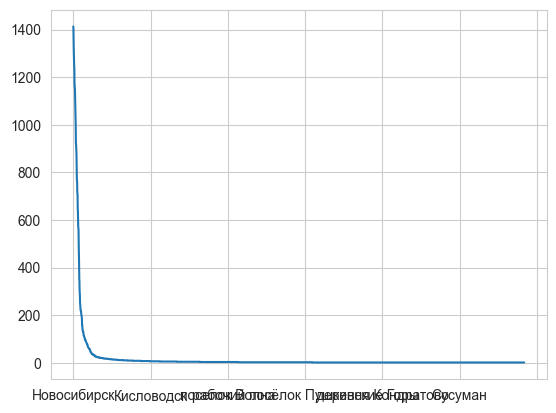

In [46]:
df['address_city'].value_counts().plot()

In [47]:
# добавим каунтер и заменим на other если значение меньше 100

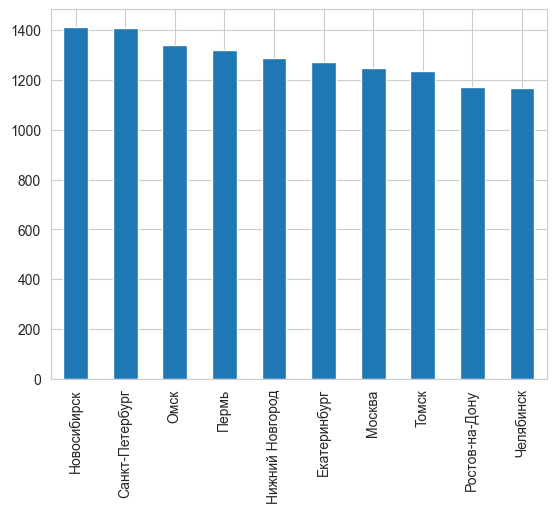

In [48]:
# топ 10 городов 
df[['address_city']].explode(column='address_city')['address_city'].value_counts()[:10].plot(kind='bar');

Города парсились равномерно, перекоса в сторону Москвы нет. Можно закодировать через target encoder.

_____________

### address.metro (ближайшее к месту работы метро)

In [49]:
df['address_metro'].unique()

array([nan])

Содержит только `NaN`. Можно удалить.

In [50]:
df = df.drop(columns=['address_metro'])

### address.metro_stations (ближайшее к месту работы метро)

In [51]:
df['metro'] = df.apply(lambda x: json.loads(x['address_metro_stations'])[0]['station_name'] if x['address_metro_stations']==x['address_metro_stations'] else x['address_metro_stations'], axis=1)

In [53]:
df = df.drop(columns=['address_metro_stations'])

Содержит адреса станций метро, расположенных рядом с местом работы.

### address.raw (адрес места работы)

In [54]:
df['address_raw'].value_counts()[:10]

город Удачный                       92
Новый Уренгой                       50
Кострома                            44
Курган, улица Ястржембского, 41А    44
Губкинский                          44
Сургут                              43
Ижевск, улица Карла Маркса, 246     43
Владикавказ                         39
Иваново, Кохомское шоссе, 1Д        36
Псков, улица Белинского, 74         35
Name: address_raw, dtype: int64

In [55]:
df = df.drop(columns=['address_raw'])

### address.street (улица)

In [56]:
df['address_street'].value_counts()[:10]

проспект Ленина       894
Советская улица       759
улица Ленина          675
улица Карла Маркса    455
Московское шоссе      363
Промышленная улица    341
Московская улица      272
улица Куйбышева       259
улица Кирова          254
проспект Мира         251
Name: address_street, dtype: int64

In [57]:
df = df.drop(columns=['address_street'])

### employer.alternate_url (ссылка на представление вакансии на сайте)

In [58]:
df["employer_alternate_url"].sample(3)

id
69532151    https://hh.ru/employer/2770390
70543629    https://hh.ru/employer/1486431
70348510      https://hh.ru/employer/44272
Name: employer_alternate_url, dtype: object

Содержит URL-ссылку на вакансию. Признак можно удалить.

In [59]:
df = df.drop(columns=["employer_alternate_url"])

### employer.name (название компании работодателя)

In [60]:
df["employer_name"].value_counts()

Яндекс                                                2709
Пятёрочка                                             1431
МАГНИТ, Розничная сеть                                1109
Консалтинг Групп                                       920
Тинькофф                                               798
                                                      ... 
Волонцевич Ирина Сергеевна                               1
Физтех-Энерго                                            1
Томский государственный педагогический университет       1
Ким Елена Владимировна                                   1
Рыбалко Антон Евгеньевич                                 1
Name: employer_name, Length: 33350, dtype: int64

<AxesSubplot: >

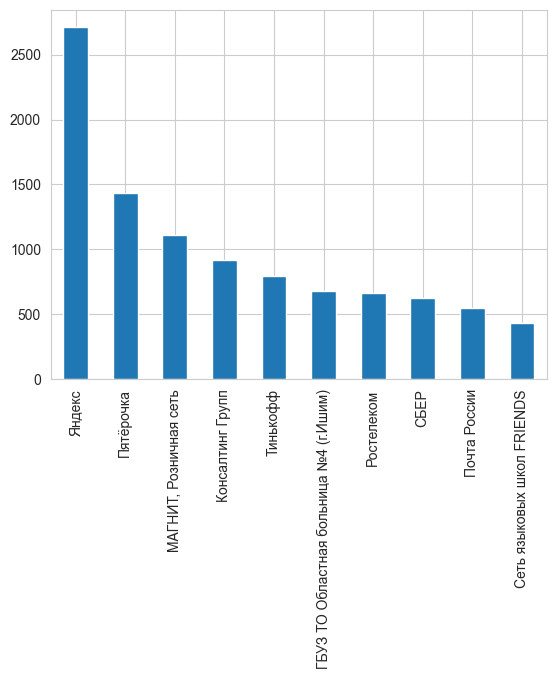

In [61]:
# топ 10 работодателей
df[['employer_name']].explode(column='employer_name')['employer_name'].value_counts()[:10].plot(kind='bar')

### employer.logo_urls

In [62]:
df[~df['employer_logo_urls'].isnull()]['employer_logo_urls']

id
69313857    [object Object]
69314349    [object Object]
70966795    [object Object]
70966796    [object Object]
69604070    [object Object]
Name: employer_logo_urls, dtype: object

Всего 5 объектов с непустым значением. Данный атрибут содержит ссылку на логотип компании-работодателя. Признак можно удалить.

In [63]:
df = df.drop(columns=["employer_logo_urls"])

### employer.url (ссылка на профиль работодателя)

In [64]:
df["employer_url"].sample(3)

id
70818304      https://api.hh.ru/employers/36575
70489795    https://api.hh.ru/employers/2123264
70657791    https://api.hh.ru/employers/5746733
Name: employer_url, dtype: object

Содержит ссылку на работодателя. Признак можно удалить.

In [65]:
df = df.drop(columns=["employer_url"])

### employer.vacancies_url (ссылка на список вакансий работодателя)

In [66]:
df["employer_vacancies_url"].sample(3)

id
71204646    https://api.hh.ru/vacancies?employer_id=3325897
70003571    https://api.hh.ru/vacancies?employer_id=4845859
71131309    https://api.hh.ru/vacancies?employer_id=3095064
Name: employer_vacancies_url, dtype: object

Содержит ссылку на вакансии работодателя. Признак можно удалить.

In [67]:
df = df.drop(columns=["employer_vacancies_url"])

### hidden (удалена ли вакансия (скрыта из архива))

In [68]:
df["hidden"].value_counts()

False    102098
Name: hidden, dtype: int64

Все значения одинаковые. Означает, что все вакансии в наборе были открыты на сайте. Признак можно удалить.

In [69]:
df = df.drop(columns=["hidden"])

### initial_created_at (дата и время создания вакансии)

In [70]:
df["initial_created_at"].value_counts()[:10]

2022-10-04T09:02:10+0300    50
2022-09-29T18:29:57+0300    50
2022-10-04T09:11:03+0300    49
2022-09-29T18:23:41+0300    45
2022-10-07T05:07:47+0300    43
2022-10-07T05:13:41+0300    41
2022-09-23T18:45:07+0300    40
2022-10-04T10:30:10+0300    39
2022-10-04T09:08:24+0300    39
2022-09-19T21:23:53+0300    37
Name: initial_created_at, dtype: int64

In [71]:
df["initial_created_at"].min()

'2015-09-25T10:15:01+0300'

In [72]:
df["initial_created_at"].max()

'2022-10-18T18:07:23+0300'

In [73]:
df = df.drop(columns=['initial_created_at'])

Содержит дату и время создания вакансии.

### name (название вакансии)

In [74]:
df["name"].describe()

count                             102098
unique                             42417
top       Менеджер по работе с клиентами
freq                                 999
Name: name, dtype: object

In [75]:
df["name"] = df["name"].str.lower()

In [78]:
df["name"].nunique()

41758

In [79]:
tfidf_cols.append("name")

Содержит название вакансии. Может понадобиться на этапе DL.

### negotiations_url (ссылка на переписку (отклики/приглашения) для работодателя)

In [80]:
df["negotiations_url"].unique()

array([nan])

 Содержит только значения `NaN`. Признак можно удалить.

In [81]:
df = df.drop(columns=["negotiations_url"])

### quick_responses_allowed (разрешены ли быстрые отклики)

In [82]:
df["quick_responses_allowed"].unique()

array([False])

Содержит только значения `False`. Признак можно удалить.

In [83]:
df = df.drop(columns=["quick_responses_allowed"])

### relations (находится ли работодатель в черном списке)

In [84]:
df["relations"].unique()

array(['[]'], dtype=object)

Содержит пустой список. Признак можно удалить.

In [85]:
df = df.drop(columns=["relations"])

### suitable_resumes_url (подходящие резюме на вакансию)

In [86]:
df["suitable_resumes_url"].unique()

array([nan])

Содержит только значения `NaN`. Признак можно удалить.

In [87]:
df = df.drop(columns=["suitable_resumes_url"])

### vacancy_constructor_template (шаблон для создания вакансии)

In [88]:
df["vacancy_constructor_template"].unique()

array([nan])

Содержит только значения `NaN`. Признак можно удалить.

In [89]:
df = df.drop(columns=["vacancy_constructor_template"])

### alternate_url (URL вакансии)

In [90]:
df["alternate_url"].sample(3)

id
70960566    https://hh.ru/vacancy/70960566
71195578    https://hh.ru/vacancy/71195578
70043269    https://hh.ru/vacancy/70043269
Name: alternate_url, dtype: object

In [91]:
# признак нужно убрать

In [92]:
df = df.drop(columns=["alternate_url"])

__________

### apply_alternate_url (ссылка на отклик на вакансию на сайте)

In [93]:
df["apply_alternate_url"].sample(3)

id
71202807    https://hh.ru/applicant/vacancy_response?vacan...
70238755    https://hh.ru/applicant/vacancy_response?vacan...
70584301    https://hh.ru/applicant/vacancy_response?vacan...
Name: apply_alternate_url, dtype: object

In [94]:
df["apply_alternate_url"].nunique()

102098

In [95]:
# признак можно убрать, все уникальные

In [96]:
df = df.drop(columns=["apply_alternate_url"])

___________

### code (внутренний код вакансии работадателя)

In [97]:
df["code"].sample(3)

id
71198307    NaN
70843575    NaN
69966689    NaN
Name: code, dtype: object

In [98]:
df["code"].value_counts()

коптз1                                  121
сгппмд                                   50
ссппзтя                                  35
нктпя360                                 35
code 4135092                             18
                                       ... 
code 4159448                              1
a066df4e-0906-440c-8036-32e7cb725800      1
23f42323-f819-4a3f-b3f4-ac4259c15cfe      1
7bd2db3f-4ec4-4b69-812c-b759719eb1d9      1
e05364ab-c264-414c-81c7-628f703ab7fa      1
Name: code, Length: 1408, dtype: int64

In [99]:
# признак можно убрать, все значения формируются работодателем не системно

In [100]:
df = df.drop(columns=["code"])

___________

### department.name (департамент, от имени которого размещается вакансия)

In [101]:
df['department_name'].sample(3)

id
70570251    NaN
70368489    NaN
70216865    NaN
Name: department_name, dtype: object

<AxesSubplot: >

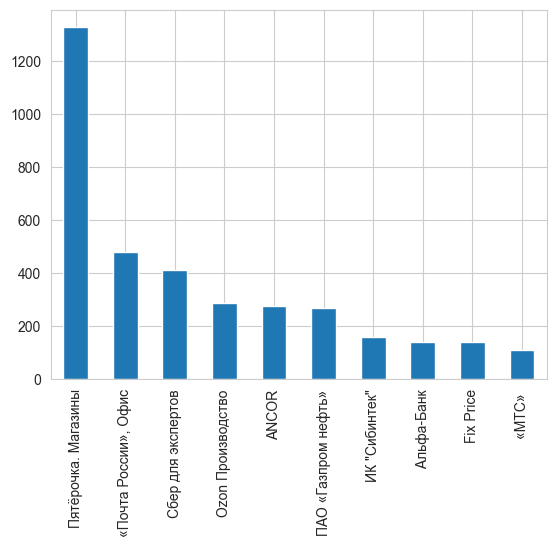

In [102]:
df['department_name'].value_counts()[:10].plot(kind='bar')

In [103]:
df['department_name'].isna().sum() / df.shape[0]

0.9389018394091951

In [104]:
df[df['department_name'].notna()]['department_name']

id
70394655    Компания «СПОРТМАСТЕР», Розничные продажи
70418962                          ПАО «Газпром нефть»
70227547                                       «МТС» 
70697997        Росгеология Административные вакансии
70859535                                 Crocus Group
                              ...                    
71045776                             Связной. Магазин
68559173                            Л'Этуаль Магазины
66894815                             Связной. Магазин
28213291                                       «МТС» 
71106458                                   Альфа-Банк
Name: department_name, Length: 6238, dtype: object

In [105]:
df['department_name'] = df['department_name'].str.lower()

In [106]:
# df['department_name'] = df['department_name'].fillna('other')

In [107]:
df['department_name'].nunique()

308

In [108]:
df['department_name'].value_counts()[:10]

пятёрочка. магазины     1326
«почта россии», офис     481
сбер для экспертов       411
ozon производство        286
ancor                    276
пао «газпром нефть»      268
ик "сибинтек"            159
 альфа-банк              142
fix price                141
«мтс»                    109
Name: department_name, dtype: int64

In [109]:
# Идентификатор департамента. Высокая кардиналость, признак можно закадировать черзе count encoder

__________

### employment.name (Название типа занятости)

In [110]:
df['employment_name'].sample(3)

id
70037092    Полная занятость
68059831    Полная занятость
70197379    Полная занятость
Name: employment_name, dtype: object

In [111]:
df['employment_name'].value_counts()

Полная занятость       95324
Частичная занятость     5804
Стажировка               626
Проектная работа         342
Волонтерство               2
Name: employment_name, dtype: int64

5 уникальных значений, признак можно закодировать через OHE.

<AxesSubplot: xlabel='employment_name'>

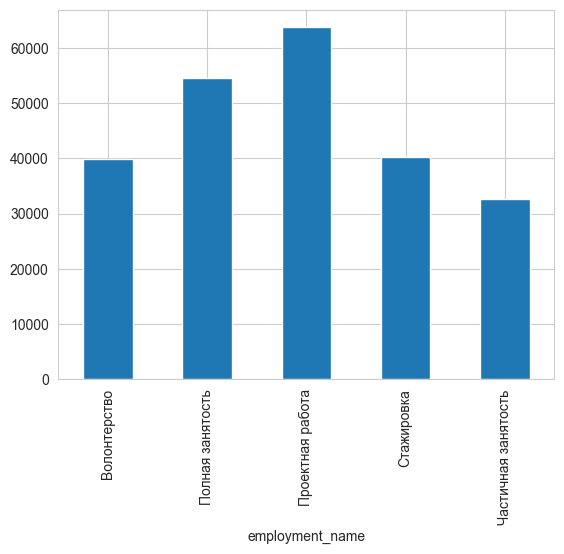

In [112]:
# график зависимости зарплаты от типа занятости
df.groupby('employment_name')['salary_mean'].mean().plot(kind="bar")

_____________

### archived (находится ли данная вакансия в архиве)

In [113]:
df['archived'].value_counts()

False    102012
True         86
Name: archived, dtype: int64

Признак можно удалить.

In [114]:
df = df.drop(columns=['archived'])

____________________

### insider_interview (интервью о жизни в компании)

In [115]:
df['insider_interview'].sample()

id
70333101   NaN
Name: insider_interview, dtype: float64

In [116]:
df = df.drop(columns = ['insider_interview'])

### area.name (название региона)

In [117]:
df['area_name'].sample(3)

id
71207278       Томск
70531074    Полярный
71180917    Кемерово
Name: area_name, dtype: object

In [118]:
df['area_name'].value_counts()

Санкт-Петербург    2408
Новосибирск        2288
Москва             2272
Омск               2224
Нижний Новгород    2121
                   ... 
Добрунь               1
Харабали              1
Судак                 1
Ерофей Павлович       1
Нолинск               1
Name: area_name, Length: 1917, dtype: int64

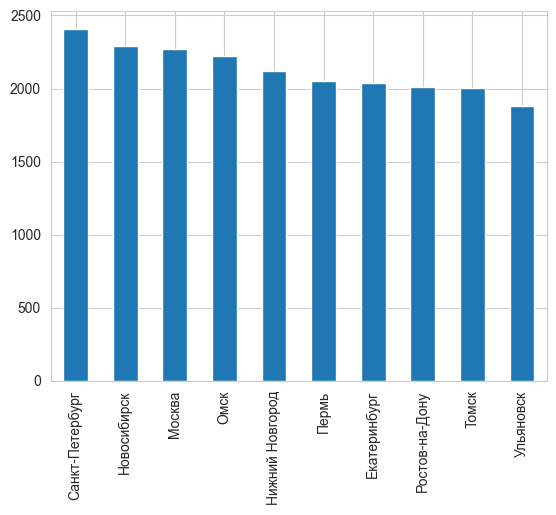

In [119]:
df[['area_name']].explode(column='area_name')['area_name'].value_counts()[:10].plot(kind='bar');

In [120]:
# df = df.drop(columns=['area_name'])

Похож на `address.city` можно закодировать через target encoder.

### area_url (URL получения информации о регионе)

In [121]:
df['area_url'].value_counts()

https://api.hh.ru/areas/2       2408
https://api.hh.ru/areas/4       2288
https://api.hh.ru/areas/1       2272
https://api.hh.ru/areas/68      2224
https://api.hh.ru/areas/66      2121
                                ... 
https://api.hh.ru/areas/4047       1
https://api.hh.ru/areas/1510       1
https://api.hh.ru/areas/2383       1
https://api.hh.ru/areas/5214       1
https://api.hh.ru/areas/1671       1
Name: area_url, Length: 1917, dtype: int64

In [122]:
df = df.drop(columns=['area_url'])

___________

### created_at (дата и время публикации вакансии)

In [123]:
df['created_at'].min()

'2022-07-15T13:28:48+0300'

In [124]:
df['created_at'].max()

'2022-10-18T18:45:22+0300'

In [131]:
df['date_diff'] = pd.to_datetime(df['published_at']) - pd.to_datetime(df['created_at'])

In [139]:
df = df.drop(columns=['created_at', 'published_at'])

In [140]:
df['date_diff'].value_counts()

0 days    102098
Name: date_diff, dtype: int64

In [142]:
df = df.drop(columns=['date_diff'])

_________

### employer.trusted (прошел ли работодатель верификацию на сайте)

In [143]:
df['employer_trusted'].sample(3)

id
69999255    True
54419178    True
71079804    True
Name: employer_trusted, dtype: bool

In [144]:
df.groupby('employer_trusted')['salary_mean'].describe()

count          mean           std    min      25%  \
employer_trusted                                                        
False              2463.0  48561.286460  32160.669892  30.00  30000.0   
True              84292.0  53467.503363  37237.207870   0.87  30000.0   

                      50%      75%       max  
employer_trusted                              
False             40000.0  57750.0  500000.0  
True              41371.2  63000.0  817500.0

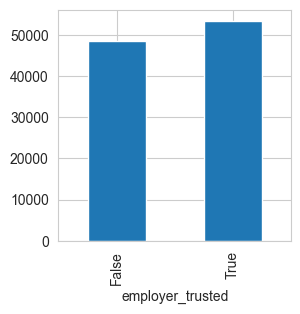

In [145]:
# график зарплаты от employer.trusted
df.groupby('employer_trusted')['salary_mean'].mean().plot(kind="bar", figsize=(3,3));

___________________

### response_letter_required (обязательно ли заполнять сообщение при отклике на вакансию)

In [146]:
df['response_letter_required'].value_counts()

False    101217
True        881
Name: response_letter_required, dtype: int64

In [147]:
df.groupby('response_letter_required')['salary_mean'].describe()

count          mean           std      min  \
response_letter_required                                                 
False                     85987.0  53291.844880  37029.519462     0.87   
True                        768.0  57400.229661  45202.675912  1609.50   

                              25%      50%      75%       max  
response_letter_required                                       
False                     30000.0  41325.0  62500.0  817500.0  
True                      34800.0  45000.0  70000.0  500000.0

Почти нет разницы в средних зарплатах.

____________

### type.name (название типа вакансии)

In [148]:
df['type_name'].sample(3)

id
69654507    Открытая
66757918    Открытая
69015976    Открытая
Name: type_name, dtype: object

In [149]:
df['type_name'].value_counts()

Открытая     101848
Анонимная       204
Рекламная        46
Name: type_name, dtype: int64

___________________

### has_test (информация о наличии прикрепленного тестового задании к вакансии)

In [151]:
df['has_test'].sample(3)

id
69348143    False
69082787    False
70869817    False
Name: has_test, dtype: bool

In [152]:
df['has_test'].value_counts()

False    101274
True        824
Name: has_test, dtype: int64

In [153]:
df.groupby('has_test')['salary_mean'].describe()

count          mean           std      min      25%      50%  \
has_test                                                                   
False     86143.0  53273.589689  37018.233361     0.87  30000.0  41325.0   
True        612.0  61017.002410  47896.733959  4450.00  32500.0  45587.5   

              75%       max  
has_test                     
False     62500.0  817500.0  
True      78300.0  500000.0

Средняя зарплата выше если есть тестовое.

___________

### response_url (URL для отклика на сайте работодателя)

In [155]:
df['response_url'].value_counts()[:10]

https://hh.ru/vrsurvey/tmk_tokar?utm_source=hh_lead_gen&utm_medium=VHR&utm_campaign=tmk_tokar                   13
https://hh.ru/article/30525?utm_source=hh_lead_gen&utm_medium=cpc&utm_campaign=X5_kladovshik_newriga_premium     7
https://hh.ru/article/28280?utm_source=hh_lead_gen&utm_medium=VHR&utm_campaign=X5_kassir_rf_premium              7
https://hh.ru/article/24852?utm_source=hh_lead_gen&utm_medium=cpc&utm_campaign=X5_director_premium               3
https://hh.ru/article/30856?utm_source=hh_lead_gen&utm_medium=vhr&utm_campaign=vit_nightstaff                    3
https://hh.ru/vacancy/69590738                                                                                   1
https://vrsurvey.hh.ru/samokat_courier?utm_source=hh_lead_gen&utm_medium=VHR&utm_campaign=samokat_kurier         1
https://hh.ru/vacancy/69703673                                                                                   1
https://hh.ru/vacancy/69421106                                                  

In [156]:
df = df.drop(columns=['response_url'])

_____________

### test (информация о прикрепленном тестовом задании к вакансии)

In [157]:
df['test'].value_counts()

Series([], Name: test, dtype: int64)

In [158]:
df = df.drop(columns=['test'])

______________

### specializations (специализации)

In [159]:
df['specializations'].sample(3).values

array(['[{"id":"1.172","name":"Начальный уровень, Мало опыта","profarea_id":"1","profarea_name":"Информационные технологии, интернет, телеком"},{"id":"1.273","name":"Системный администратор","profarea_id":"1","profarea_name":"Информационные технологии, интернет, телеком"},{"id":"1.82","name":"Инженер","profarea_id":"1","profarea_name":"Информационные технологии, интернет, телеком"},{"id":"1.211","name":"Поддержка, Helpdesk","profarea_id":"1","profarea_name":"Информационные технологии, интернет, телеком"},{"id":"1.89","name":"Интернет","profarea_id":"1","profarea_name":"Информационные технологии, интернет, телеком"}]',
       '[{"id":"21.275","name":"Складское хозяйство","profarea_id":"21","profarea_name":"Транспорт, логистика"},{"id":"21.563","name":"Кладовщик","profarea_id":"21","profarea_name":"Транспорт, логистика"},{"id":"21.564","name":"Рабочий склада","profarea_id":"21","profarea_name":"Транспорт, логистика"},{"id":"21.136","name":"Логистика","profarea_id":"21","profarea_name":"Т

In [160]:
df['specializations'] = df.apply(lambda x: eval(x['specializations']) if isinstance(x['specializations'], str) else x['specializations'], axis=1)
df['spec_area'] = df.apply(lambda x: [i['profarea_name'] for i in x['specializations']] if isinstance(x['specializations'], list) else x['specializations'], axis=1)
df['spec_area'] = df.apply(lambda x:  ", ".join(list(set(x['spec_area']))).lower() if x['spec_area'] == x['spec_area'] else x['spec_area'], axis=1)

In [161]:
df['spec_area'].head()

id
69761814    продажи, начало карьеры, студенты
69683316            административный персонал
70089465                              продажи
70891988                              продажи
70394655    продажи, начало карьеры, студенты
Name: spec_area, dtype: object

In [162]:
df = df.drop(columns=['specializations'])

In [164]:
tfidf_cols.append('spec_area')

____________

### contacts (контактная информация)

In [165]:
df['contacts'].value_counts()

Series([], Name: contacts, dtype: int64)

In [166]:
df = df.drop(columns='contacts')

____________

### billing_type.name (название биллингового типа вакансии)

In [167]:
df['billing_type_name'].value_counts()

Стандарт         95089
Стандарт плюс     6915
Премиум             94
Name: billing_type_name, dtype: int64

________

### allow_messages (включена ли возможность соискателю писать сообщения работодателю, после приглашения/отклика на вакансию)

In [168]:
df['allow_messages'].value_counts()

True     94070
False     8028
Name: allow_messages, dtype: int64

In [169]:
df.groupby('allow_messages')['salary_mean'].describe()

count          mean           std    min      25%      50%  \
allow_messages                                                                 
False            6949.0  48467.635159  34478.282379  34.80  28057.5  39000.0   
True            79806.0  53751.442816  37302.178808   0.87  30000.0  42195.0   

                    75%       max  
allow_messages                     
False           55000.0  504600.0  
True            65000.0  817500.0

Более общительные работодатели платят больше.

________

### premium (является ли данная вакансия премиум-вакансией)

In [170]:
df['premium'].value_counts()

False    102004
True         94
Name: premium, dtype: int64

In [171]:
df.groupby('premium')['salary_mean'].describe()

count          mean           std       min      25%      50%  \
premium                                                                    
False    86678.0  53328.249969  37113.701134      0.87  30000.0  41325.0   
True        77.0  53288.197468  34709.643855  13000.00  30537.0  46240.5   

             75%       max  
premium                     
False    62500.0  817500.0  
True     60000.0  250000.0

___________

У premium вакансий средняя зарплата выше.

### driver_license_types (список требуемых категорий водительских прав)

In [172]:
df['driver_license_types'].value_counts()[:10]

[]                                     100245
[{"id":"B"}]                              839
[{"id":"B"},{"id":"C"}]                   310
[{"id":"C"}]                              212
[{"id":"D"}]                               70
[{"id":"C"},{"id":"E"},{"id":"CE"}]        47
[{"id":"CE"}]                              38
[{"id":"E"}]                               36
[{"id":"B"},{"id":"C"},{"id":"D"}]         36
[{"id":"C"},{"id":"E"}]                    33
Name: driver_license_types, dtype: int64

In [173]:
df['driver_license_types'] = df.apply(lambda x: eval(x['driver_license_types']) if isinstance(x['driver_license_types'], str) else x['driver_license_types'], axis=1)
df['driver_license'] = df.apply(lambda x: ", ".join([i['id'] for i in x['driver_license_types']]).lower() if isinstance(x['driver_license_types'], list) else x['driver_license_types'], axis=1)


In [174]:
df['driver_license'].value_counts()[:10]

            100245
b              839
b, c           310
c              212
d               70
c, e, ce        47
ce              38
e               36
b, c, d         36
c, e            33
Name: driver_license, dtype: int64

In [175]:
df = df.drop(columns=['driver_license_types'])

Из признака можно будет сделать векторное представление через tfidf и попробовать использовать его в модели.

________

### accept_incomplete_resumes (разрешен ли отклик на вакансию неполным резюме)

In [176]:
df['accept_incomplete_resumes'].value_counts()

False    63315
True     38783
Name: accept_incomplete_resumes, dtype: int64

In [177]:
df.groupby('accept_incomplete_resumes')['salary_mean'].describe()

count          mean           std     min  \
accept_incomplete_resumes                                                
False                      51197.0  54984.937145  38671.621616   0.870   
True                       35558.0  50942.837478  34603.735789  14.355   

                               25%      50%      75%       max  
accept_incomplete_resumes                                       
False                      30450.0  43500.0  65000.0  817500.0  
True                       29580.0  40000.0  60900.0  515000.0

Заполни резюме и получай больше денег ;)

________

### working_days (рабочие дни)

In [178]:
df['working_days'].value_counts()

[]                                                                       100489
[{"id":"only_saturday_and_sunday","name":"Работа только по сб и вс"}]      1609
Name: working_days, dtype: int64

In [179]:
df['working_days'] = df.apply(lambda x: True if len(x['working_days'])>2 else False,axis=1)

In [180]:
df['working_days'].value_counts()

False    100489
True       1609
Name: working_days, dtype: int64

In [181]:
df.groupby('working_days')['salary_mean'].describe()

count          mean           std    min      25%      50%  \
working_days                                                                 
False         85361.0  53407.813230  37230.179978   0.87  30000.0  41325.0   
True           1394.0  48454.015039  28516.814050  34.80  30000.0  40089.6   

                  75%       max  
working_days                     
False         62500.0  817500.0  
True          68340.0  250000.0

Работа только на выходных оплачивается меньше.

_____________

### working_time_intervals (временные интервалы работы)

In [182]:
df['working_time_intervals'].value_counts()

[]                                                                                                97103
[{"id":"from_four_to_six_hours_in_a_day","name":"Можно работать сменами по 4–6 часов в день"}]     4995
Name: working_time_intervals, dtype: int64

In [183]:
df['working_time_intervals'] = df.apply(lambda x: True if len(x['working_time_intervals'])>2 else False,axis=1)

In [184]:
df['working_time_intervals'].value_counts()

False    97103
True      4995
Name: working_time_intervals, dtype: int64

In [185]:
df.groupby('working_time_intervals')['salary_mean'].describe()

count          mean           std    min      25%  \
working_time_intervals                                                        
False                   82277.0  53989.581249  37470.302656   0.87  30015.0   
True                     4478.0  41176.522023  27018.120581  33.06  23925.0   

                            50%      75%       max  
working_time_intervals                              
False                   42500.0  65000.0  817500.0  
True                    33575.0  50000.0  435000.0

Работа по интервалам оплачивается меньше.

___________________

### working_time_modes (режимы времени работы)

In [186]:
df['working_time_modes'].value_counts()

[]                                                                             98158
[{"id":"start_after_sixteen","name":"Можно начинать работать после 16:00"}]     3940
Name: working_time_modes, dtype: int64

In [187]:
df['working_time_modes'] = df.apply(lambda x: True if len(x['working_time_modes'])>2 else False,axis=1)

In [188]:
df.groupby('working_time_modes')['salary_mean'].describe()

count          mean           std    min      25%  \
working_time_modes                                                        
False               83219.0  53855.917409  37384.661116   0.87  30000.0   
True                 3536.0  40908.838016  27160.096924  34.80  23490.0   

                        50%      75%       max  
working_time_modes                              
False               42000.0  64483.5  817500.0  
True                32500.0  52275.0  435000.0

In [189]:
df = df.drop(columns=['working_time_modes'])

Работа позже 16 оплачивается меньше.

_________________

### accept_temporary (указание, что вакансия доступна для соискателей с временным трудоустройством)

In [190]:
df['accept_temporary'].value_counts()

False    93851
True      8247
Name: accept_temporary, dtype: int64

In [191]:
df.groupby('accept_temporary')['salary_mean'].describe()

count          mean           std    min      25%  \
accept_temporary                                                        
False             79258.0  52722.596658  36855.176849   0.87  30000.0   
True               7497.0  59730.782470  39153.406583  33.06  31000.0   

                      50%      75%       max  
accept_temporary                              
False             40020.0  60900.0  817500.0  
True              49500.0  78300.0  650000.0

_________________

### professional_roles (массив объектов профролей)

In [192]:
df['professional_roles']

id
69761814    [{"id":"97","name":"Продавец-консультант, прод...
69683316    [{"id":"110","name":"Секретарь, помощник руков...
70089465    [{"id":"70","name":"Менеджер по продажам, мене...
70891988    [{"id":"70","name":"Менеджер по продажам, мене...
70394655    [{"id":"97","name":"Продавец-консультант, прод...
                                  ...                        
69018160                     [{"id":"52","name":"Кладовщик"}]
71208606    [{"id":"68","name":"Менеджер по маркетингу, ин...
70160376                  [{"id":"8","name":"Администратор"}]
71279521                     [{"id":"18","name":"Бухгалтер"}]
70936655     [{"id":"89","name":"Официант, бармен, бариста"}]
Name: professional_roles, Length: 102098, dtype: object

In [193]:
df['professional_roles'] = df.apply(lambda x: eval(x['professional_roles']) if isinstance(x['professional_roles'], str) else x['professional_roles'], axis=1)
df['prof_role'] = df.apply(lambda x: [i['name'] for i in x['professional_roles']] if isinstance(x['professional_roles'], list) else x['professional_roles'], axis=1)
df['prof_role'] = df.apply(lambda x:  ", ".join(list(set(x['prof_role']))).lower() if x['prof_role'] == x['prof_role'] else x[['prof_role']], axis=1)

In [194]:
df = df.drop(columns=['professional_roles'])

In [195]:
df['prof_role'].value_counts()[:10]

другое                                                  9493
продавец-консультант, продавец-кассир                   6194
менеджер по продажам, менеджер по работе с клиентами    5572
водитель                                                4715
специалист технической поддержки                        3621
программист, разработчик                                3219
бухгалтер                                               2961
администратор                                           2918
упаковщик, комплектовщик                                2577
врач                                                    2399
Name: prof_role, dtype: int64

In [196]:
tfidf_cols.append('prof_role')

______________

### languages (список языков)

In [197]:
df.languages.value_counts()[:10]

[]                                                                                         100316
[{"id":"eng","name":"Английский","level":{"id":"a1","name":"A1 — Начальный"}}]                787
[{"id":"eng","name":"Английский","level":{"id":"b1","name":"B1 — Средний"}}]                  338
[{"id":"eng","name":"Английский","level":{"id":"b2","name":"B2 — Средне-продвинутый"}}]       249
[{"id":"eng","name":"Английский","level":{"id":"a2","name":"A2 — Элементарный"}}]             123
[{"id":"eng","name":"Английский","level":{"id":"c1","name":"C1 — Продвинутый"}}]              118
[{"id":"rus","name":"Русский","level":{"id":"c2","name":"C2 — В совершенстве"}}]               39
[{"id":"rus","name":"Русский","level":{"id":"a1","name":"A1 — Начальный"}}]                    32
[{"id":"eng","name":"Английский","level":{"id":"c2","name":"C2 — В совершенстве"}}]            12
[{"id":"rus","name":"Русский","level":{"id":"c1","name":"C1 — Продвинутый"}}]                   9
Name: languages, dty

In [198]:
df['languages'] = df.apply(lambda x: eval(x['languages']) if isinstance(x['languages'], str) else x['languages'], axis=1)

In [199]:
df['languages'] = df.apply(lambda x: " ".join([str(i['name']) + ' ' + str(i['level']['id'])  for i in x['languages']]).lower() if isinstance(x['languages'], list) else x['languages'], axis=1)

In [200]:
df['languages'].value_counts()[:10]

                 100316
английский a1       787
английский b1       338
английский b2       249
английский a2       123
английский c1       118
русский c2           39
русский a1           32
английский c2        12
русский c1            9
Name: languages, dtype: int64

### Рассчитать основные статистики для вещественных и категориальных признаков (df.describe(include=’all’))

In [201]:
df.shape

(102098, 33)

In [203]:
df.describe()

address_description   address_lat   address_lng    salary_mean
count                  0.0  55116.000000  55116.000000   86755.000000
mean                   NaN     55.123418     55.296017   53328.214421
std                    NaN      5.667612     25.233171   37111.449342
min                    NaN      0.000000      0.000000       0.870000
25%                    NaN     53.224336     38.980022   30000.000000
50%                    NaN     55.730223     47.247728   41325.000000
75%                    NaN     57.624082     65.341118   62500.000000
max                    NaN     76.225000    179.367026  817500.000000

In [204]:
df = df.drop(columns=['address_description'])

In [206]:
df[tfidf_cols]

description  \
id                                                            
69761814  приветствуем вас! мы рады, что вы проявили инт...   
69683316  обязанности:   -ведение деловой переписки; -ве...   
70089465  компания &quot;обаяние продаж&quot; более 10 л...   
70891988  обязанности:  продажа керамической плитки; кон...   
70394655  портмастер - лидер на рынке спортивных товаров...   
...                                                     ...   
69018160  привет, мы –один из ведущих поставщиков товаро...   
71208606  обязанности:  разработка маркетинговой стратег...   
70160376  обязанности:✍ приём и выдача интернет - заказо...   
71279521  обязанности:  ведение бухгалтерского учета по ...   
70936655  в связи с открытием нового ресторана &quot; хл...   

                                                 key_skills  \
id                                                            
69761814  активные продажи, грамотная речь, проведение п...   
69683316  протоколирование, делопроизводство, грамотная ...   
70089465  поиск и привлечение клиентов, активные продажи...   
70891988  активные продажи, ceramic 3d, прямые продажи, ...   
70394655  активные продажи, навыки продаж, работа в кома...   
...                                                     ...   
69018160  1с: склад, оформление документации, пользовате...   
71208606                                                NaN   
70160376  умение работать в команде, пользователь пк, ст...   
71279521  работа в условиях многозадачности, умение рабо...   
70936655  общественное питание, умение работать в команд...   

                                                       name  \
id                                                            
69761814  продавец-консультант в сеть бутиков товаров пр...   
69683316                                  помощник депутата   
70089465          менеджер по продажам (услуги для бизнеса)   
70891988           менеджер по продажам керамической плитки   
70394655                               продавец-консультант   
...                                                     ...   
69018160                         кладовщик-наборщик товаров   
71208606                                         маркетолог   
70160376               администратор в пункт выдачи заказов   
71279521                            бухгалтер по материалам   
70936655        официант в ресторан "хлеб&пицца для друзей"   

                                                  spec_area  \
id                                                            
69761814                  продажи, начало карьеры, студенты   
69683316                          административный персонал   
70089465                                            продажи   
70891988                                            продажи   
70394655                  продажи, начало карьеры, студенты   
...                                                     ...   
69018160                               транспорт, логистика   
71208606                             маркетинг, реклама, pr   
70160376  продажи, административный персонал, спортивные...   
71279521  бухгалтерия, управленческий учет, финансы пред...   
70936655  начало карьеры, студенты, туризм, гостиницы, р...   

                                                  prof_role  
id                                                           
69761814              продавец-консультант, продавец-кассир  
69683316        секретарь, помощник руководителя, ассистент  
70089465  менеджер по продажам, менеджер по работе с кли...  
70891988  менеджер по продажам, менеджер по работе с кли...  
70394655              продавец-консультант, продавец-кассир  
...                                                     ...  
69018160                                          кладовщик  
71208606        менеджер по маркетингу, интернет-маркетолог  
70160376                                      администратор  
71279521                                          бухгалтер  
70936655                

In [207]:
df.dtypes.value_counts()

object     18
bool       11
float64     3
dtype: int64

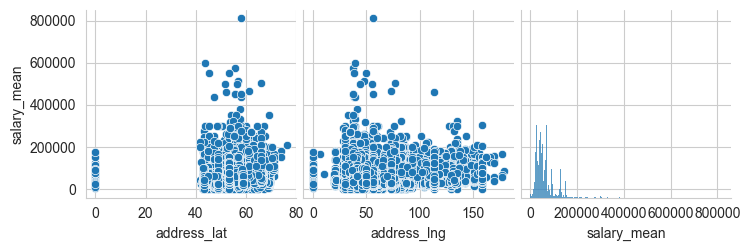

In [208]:
float_cols = df.select_dtypes('float64').columns.to_list()
int_cols = df.select_dtypes('int64').columns.to_list()
num_cols = float_cols + int_cols
pp = sns.pairplot(data=df,
                  y_vars=['salary_mean'],
                  x_vars=num_cols)

In [209]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Scattergeo(
        lon = df['address_lng'],
        lat = df['address_lat'],
        mode = 'markers',
        marker_color = df['salary_mean'],
        ))

fig.update_layout(
        title = 'Средняя зарплата',
        geo_scope='world',
    )
fig.show()

In [ ]:
# drop_cols = [
    # 'department.name',,
    # 'driver_license_types.name',
    # 'languages.name_level',
    # 'salary.gross',
    # 'initial_created_at',
    # 'address.metro',
    # 'address.description',
    # 'employer.alternate_url',
    # 'address.street',
    # 'address.city',
    # 'address.metro_stations',
    # 'address.raw']

In [210]:
# drop_cols += [i for i in df.columns.to_list() if 'created' in i.split('_')[0]]

In [211]:
df.shape

(102098, 32)

In [214]:
text_cols = ['description', 'key_skills', 'name', 'spec_area', 'prof_role']

In [212]:
df.to_csv("../data/interim/data.csv",index=False)